# combining df

In [108]:
import pandas as pd

metric_dfs = []
perf_dfs = []
for v in ["0.5.0", "0.4.1"]:
    mdf = pd.read_csv(f"../data/eval/metric_{v}.csv")
    metric_dfs.append(mdf)
    pdf = pd.read_csv(f"../data/eval/perf_{v}.csv")
    perf_dfs.append(pdf)

combined_mdf = pd.concat(metric_dfs)
combined_pdf = pd.concat(perf_dfs)

combined_mdf.to_csv("../data/eval/metric_combined.csv", index=False)
combined_pdf.to_csv("../data/eval/perf_combined.csv", index=False)
    

In [109]:
import pandas as pd

mdf = pd.read_csv("../data/eval/metric_combined.csv")
pdf = pd.read_csv("../data/eval/perf_combined.csv")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_perf(df, plot_path=None):
    df = df.copy()
    agg = df.groupby(["command", "num_samples", "version"], as_index=False)["elapsed_time"].mean()
    wide = agg.pivot_table(index=["command", "num_samples"], columns="version", values="elapsed_time")
    wide = wide.dropna(subset=["0.4.1", "0.5.0"]).reset_index()
    wide["speedup"] = wide["0.4.1"] / wide["0.5.0"]
    wide["num_samples"] = pd.Categorical(wide["num_samples"], categories=sorted(wide["num_samples"].unique()), ordered=True)
    label_map = {"match_ancestors": "Match ancestors", "match_samples": "Match samples"}
    wide["command"] = wide["command"].map(label_map)

    plt.figure(figsize=(6, 4))
    ax = sns.barplot(
        data=wide,
        x="num_samples",
        y="speedup",
        hue="command",
        palette={"Match ancestors": "#9fc8c8", "Match samples": "#298c8c"},
        hue_order=["Match ancestors", "Match samples"],
        dodge=True,
    )
    ax.set_xlabel("Number of samples")
    ax.set_ylabel("Speedup")
    ax.legend(title="Inference step", loc="best")
    plt.tight_layout()
    if plot_path:
        plt.savefig(plot_path, bbox_inches="tight", dpi=300)
        plt.close()
    else:
        plt.show()



def plot_metric(df, metric, ax=None, palette=None, title=None, ylabel=None):
    d = (
        df.groupby(["version", "num_samples"], as_index=False)[metric]
        .agg(mean="mean", std="std", n="count")
    )
    d["sem"] = d["std"] / np.sqrt(d["n"])
    d["ci"] = 1.96 * d["sem"]
    cats = sorted(d["num_samples"].unique())
    x = np.arange(len(cats))
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    if palette is None:
        palette = {"0.5.0": "#ea801c", "0.4.1": "#1a80bb"}
    for v in ["0.5.0", "0.4.1"]:
        dv = d[d["version"] == v].set_index("num_samples").reindex(cats)
        y = dv["mean"].values
        yerr = dv["ci"].values
        ax.errorbar(
            x,
            y,
            yerr=yerr,
            fmt="o-",
            color=palette.get(v, "#666"),
            ecolor=palette.get(v, "#666"),
            elinewidth=1.5,
            capsize=6,
            capthick=1.5,
            markersize=5,
        )
    ax.set_xticks(x, [str(c) for c in cats])
    ax.set_xlabel("Number of samples")
    ax.set_ylabel(ylabel if ylabel else metric)
    ax.set_title(title if title else metric)
    ax.legend(["0.5.0", "0.4.1"], title="Version")
    y_max = float(np.nanmax((d["mean"] + d["ci"]).to_numpy()))
    ax.set_ylim(0, y_max*1.05)
    return ax

def plot_metric_panel(df, metrics=("kc_dist", "rf_dist", "arf_dist"), titles=None, ylabels=None, plot_path=None):
    if titles is None:
        titles = ["Kendall-Colijn distance", "Robinson-Foulds distance", "ARF distance (tscompare)"]
    if ylabels is None:
        ylabels = ["KC distance (split polytomies)", "RF distance (split polytomies)", "ARF"]
    fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharex=True)
    for i, m in enumerate(metrics):
        plot_metric(df, m, ax=axes[i], title=titles[i], ylabel=ylabels[i])
    plt.tight_layout()
    if plot_path:
        plt.savefig(plot_path, bbox_inches="tight", dpi=300)
        plt.close()
    else:
        plt.show()
plot_perf(pdf, plot_path="../results/perf.png")

plot_metric_panel(mdf, plot_path="../results/metrics.png")

## New in 0.5.0: Greatly improved computational performance

`0.5.0` introduces an internal change to the first step of the `tsinfer` algorithm, ancestor generation, that greatly improves computational performance overall. We noticed that the ancestors we assume to be the oldest, corresponding to focal sites with a high frequency, were generated to be unrealistically long. By adjusting the algorithm to better utilise the genotype data during ancestor building, ancestor lengths no longer increase with their relative age. We can see this in the simulation results below of a 10mbp region with 7000 samples:

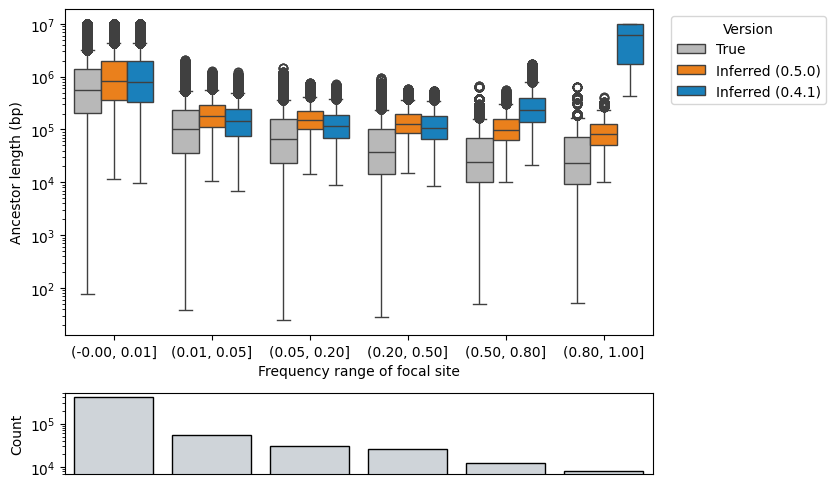

In [101]:
import os
import sys
import importlib

sys.path.append("../lib")
import visualisation as viz
importlib.reload(viz)
cutoffs = [0,0.01,0.05,0.2,0.5,0.8,1.0]
viz.plot_ancestor_boxplot(df, type="pos", 
                          var="span", 
                          y_log=True,
                          cutoffs=cutoffs,
                          title=None)

The changes in `0.5.0` greatly improve computational scaling of the most demanding steps of `tsinfer` (matching ancestors and matching samples). As seen in the simulation benchmark below of a 10mbp region, the improvement scales with sample size.

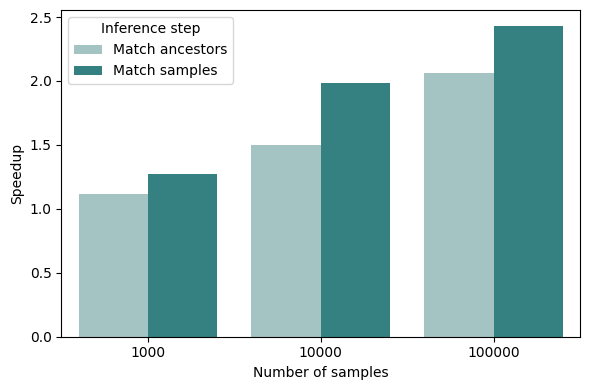

In [102]:
plot_perf(pdf)

We have done extensive validation of the changes in `0.5.0` and have found no significant differences in inference accuracy. For example, we computed a weighted average of Kendall-Colijn and Robinsons-Foulds distances with a simulation of 1 mbp below, along with the recently published ARF dissimilarity score available in [tscompare](https://tskit.dev/software/tscompare.html). For each sample size, 10 simulations were performed and the metrics were calculated for each. No significant difference between the performance of the versions was observed with any metric.

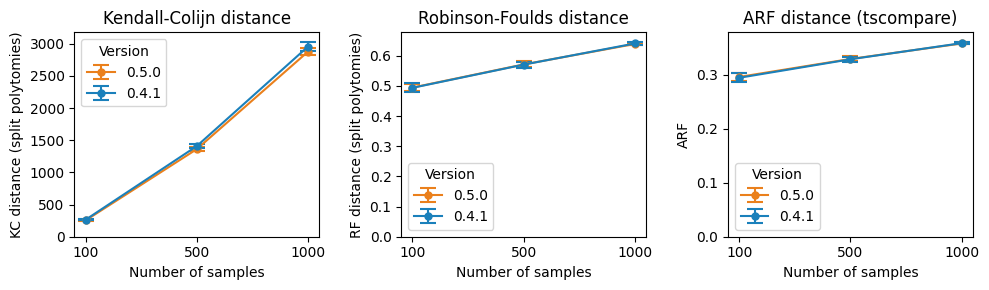

In [107]:
plot_metric_panel(mdf)

A detailed description and validation of the internal changes in `0.5.0` will be published in future. We strongly recommend upgrading to this version if you are using `tsinfer` on large datasets; we have observed speedups of over 8X in some cases.

# Scratch

In [7]:
import numpy as np
import pandas as pd
import msprime
import tskit
import tsinfer

num_samples = 100
seq_length = 1e6
seed = 3

ts_base = msprime.sim_ancestry(
    num_samples,
    sequence_length=seq_length,
    random_seed=seed,
    recombination_rate=1.29e-8,
    population_size=1e4
)
ts = msprime.sim_mutations(ts_base, rate=1.29e-8, random_seed=2)
sample_data = tsinfer.SampleData.from_tree_sequence(unsimp_true_ts)
anc_data = tsinfer.generate_ancestors(sample_data)
ancestors_ts = tsinfer.match_ancestors(sample_data, anc_data, num_threads=8)
raw_ts = tsinfer.match_samples(sample_data, ancestors_ts, num_threads=8, post_process=False)
unsimp_inf_ts = tsinfer.post_process(raw_ts)

true_ts = unsimp_true_ts.simplify()
inf_ts = unsimp_inf_ts.simplify()
num_intervals = len(list(inf_ts.coiterate(true_ts)))

weighted_kc = np.zeros(num_intervals)
weighted_rf = np.zeros(num_intervals)

for i, (interval, inf_tree, true_tree) in enumerate(inf_ts.coiterate(true_ts, sample_lists=True)):
    if inf_tree.num_edges > 0 and true_tree.num_edges > 0:
        length = interval.right - interval.left
        split_tree = inf_tree.split_polytomies(method="random", sample_lists=True, random_seed=1)
        kc = split_tree.kc_distance(true_tree)
        weighted_kc[i] = split_tree.kc_distance(true_tree) * length
        weighted_rf[i] = split_tree.rf_distance(true_tree) * length

total_length = right - left
n = inf_ts.num_samples
kc = np.sum(weighted_kc) / total_length
rf = np.sum(weighted_rf) / (total_length*(2*n-4))
rf

0.5832733275862069

In [ ]:
import numpy as np
import pandas as pd
import msprime
import tskit
import tsinfer

def generate_ts(ts_base, seed):
    ts = msprime.sim_mutations(ts_base, rate=1.29e-8, random_seed=seed)
    sample_data = tsinfer.SampleData.from_tree_sequence(ts)
    anc = tsinfer.generate_ancestors(sample_data)
    ancestors_ts = tsinfer.match_ancestors(sample_data, anc)
    raw_ts = tsinfer.match_samples(sample_data, ancestors_ts, post_process=False)
    inf_ts = tsinfer.post_process(raw_ts).simplify()
    true_ts = ts.simplify()
    return true_ts, inf_ts

def calculate_metrics(true_ts, inf_ts, seed):
    L = true_ts.sequence_length
    n = inf_ts.num_samples
    weighted_kc = []
    weighted_rf = []
    for interval, inf_tree, true_tree in inf_ts.coiterate(true_ts, sample_lists=True):
        if inf_tree.num_edges > 0 and true_tree.num_edges > 0:
            length = interval.right - interval.left
            split_tree = inf_tree.split_polytomies(method="random", sample_lists=True, random_seed=seed)
            weighted_kc.append(split_tree.kc_distance(true_tree) * length)
            weighted_rf.append(split_tree.rf_distance(true_tree) * length)
    kc = np.sum(weighted_kc) / L
    rf = np.sum(weighted_rf) / (L * (2 * n - 4))
    return kc, rf


In [34]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sgkit
import zarr

df = pd.read_csv("../data/anc_eval/dataframes/OutOfAfrica_4J17-chr20-L4e7-R5e7-n3000-s3-rep0-gerr_disabled-ser0-mper0-ancestors.csv")
mapping = {"0.4": "0.4.1", "1.0": "0.5.0"}
df["version"] = df["version"].astype(str).replace(mapping)
df

,inferred_node,true_node,replicate,error_profile,genotype_errors_added,switch_error_rate,mispolarisation_error_rate,version,side,inf_focal_site,...,true_boundary,true_span,inferred_boundary,inferred_span,overlap_boundary,overlap_span,num_errors,num_should_be_0,num_should_be_1,overshoot
0,2,208615,0,none,False,0,0,0.4.1,left,69038,...,44968588.0,72479.0,40000061.0,9999932.0,44968588.0,72479.0,11,11,0,4968527.0
1,2,208615,0,none,False,0,0,0.4.1,right,69038,...,45041067.0,72479.0,49999993.0,9999932.0,45041067.0,72479.0,11,11,0,4958926.0
2,2,208615,0,none,False,0,0,0.5.0,left,69038,...,44968588.0,72479.0,44962541.0,190696.0,44968588.0,72479.0,11,11,0,6047.0
3,2,208615,0,none,False,0,0,0.5.0,right,69038,...,45041067.0,72479.0,45153237.0,190696.0,45041067.0,72479.0,11,11,0,112170.0
4,2,208615,0,none,False,0,0,0.4.1,left,69165,...,44968588.0,72479.0,40000061.0,9999932.0,44968588.0,72479.0,11,11,0,4968527.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547039,68719,40895,0,none,False,0,0,0.5.0,right,39674,...,42932532.0,767765.0,42973252.0,386483.0,42932532.0,345763.0,1,1,0,40720.0
547040,68720,33143,0,none,False,0,0,0.4.1,left,37318,...,42629760.0,222483.0,42622363.0,233745.0,42629760.0,222483.0,4,4,0,7397.0
547041,68720,33143,0,none,False,0,0,0.4.1,right,37318,...,42852243.0,222483.0,42856108.0,233745.0,42852243.0,222483.0,4,4,0,3865.0
547042,68720,33143,0,none,False,0,0,0.5.0,left,37318,...,42629760.0,222483.0,42622363.0,233745.0,42629760.0,222483.0,4,4,0,7397.0


In [9]:
df[["version", "true_span", "inferred_span"]]

,version,true_span,inferred_span
0,0.4.1,64379.0,19999904.0
1,0.4.1,64379.0,19999904.0
2,0.5.0,64379.0,192042.0
3,0.5.0,64379.0,192042.0
4,0.4.1,64379.0,19999904.0
...,...,...,...
1370331,0.5.0,359802.0,469045.0
1370332,0.4.1,6626282.0,6225945.0
1370333,0.4.1,6626282.0,6225945.0
1370334,0.5.0,6626282.0,6483107.0


In [3]:
df.columns

Index(['inferred_node', 'true_node', 'replicate', 'error_profile',
       'genotype_errors_added', 'switch_error_rate',
       'mispolarisation_error_rate', 'version', 'side', 'inf_focal_site',
       'true_focal_site', 'focal_position', 'focal_site_mispolarised',
       'focal_site_geno_error_count', 'allele_frequency', 'true_time',
       'inferred_time', 'true_boundary', 'true_span', 'inferred_boundary',
       'inferred_span', 'overlap_boundary', 'overlap_span', 'num_errors',
       'num_should_be_0', 'num_should_be_1', 'overshoot'],
      dtype='object')

In [11]:
df.version.value_counts()

version
0.4.1    685168
0.5.0    685168
Name: count, dtype: int64

In [29]:
df.loc[df["version"]=="0.5.0"]

,inferred_node,true_node,replicate,error_profile,genotype_errors_added,switch_error_rate,mispolarisation_error_rate,version,side,inf_focal_site,...,true_boundary,true_span,inferred_boundary,inferred_span,overlap_boundary,overlap_span,num_errors,num_should_be_0,num_should_be_1,overshoot
2,2,192481,0,none,False,0,0,0.5.0,left,103859,...,26021746.0,64379.0,25912193.0,192042.0,26021746.0,64379.0,1,1,0,109553.0
3,2,192481,0,none,False,0,0,0.5.0,right,103859,...,26086125.0,64379.0,26104235.0,192042.0,26086125.0,64379.0,1,1,0,18110.0
6,2,192481,0,none,False,0,0,0.5.0,left,103871,...,26021746.0,64379.0,25912193.0,192042.0,26021746.0,64379.0,1,1,0,109553.0
7,2,192481,0,none,False,0,0,0.5.0,right,103871,...,26086125.0,64379.0,26104235.0,192042.0,26086125.0,64379.0,1,1,0,18110.0
10,2,192481,0,none,False,0,0,0.5.0,left,103899,...,26021746.0,64379.0,25912193.0,192042.0,26021746.0,64379.0,1,1,0,109553.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1370327,27894,123321,0,none,False,0,0,0.5.0,right,214672,...,32652498.0,579436.0,32678847.0,230776.0,32644496.0,193977.0,0,0,0,26349.0
1370330,27895,166592,0,none,False,0,0,0.5.0,left,209254,...,32099553.0,359802.0,32051744.0,469045.0,32099553.0,359802.0,5,5,0,47809.0
1370331,27895,166592,0,none,False,0,0,0.5.0,right,209254,...,32459355.0,359802.0,32520789.0,469045.0,32459355.0,359802.0,5,5,0,61434.0
1370334,27896,121538,0,none,False,0,0,0.5.0,left,183386,...,24633503.0,6626282.0,25039699.0,6483107.0,25040671.0,6219114.0,2,0,2,-406196.0


In [63]:
import os
import sys
import importlib

sys.path.append("../lib")
import visualisation as viz
importlib.reload(viz)
cutoffs = [0,0.01,0.05,0.2,0.5,0.8,1.0]
viz.plot_ancestor_boxplot(df, type="pos", var="span", y_log=True,cutoffs=cutoffs, title=None, plot_path = "../results/ancestor_lengths.png")

In [26]:
df.version.value_counts()

version
0.4.1    138956
Name: count, dtype: int64

In [20]:
df.version.value_counts()

version
0.4.1    138956
Name: count, dtype: int64